##  2.0 Assignment 2  

The goal of this assignment is to create a model that can perform sentimental analysis. To achieve this we'll be training it on the provided dataset, containing sentiments classfied as positive, neutral, or negative. Throughout the assignment we will elaborate why some things are done, and why some things were used over others.

**Required Imports/Downloads**

In [1]:
%pip install spacy imblearn nltk numpy pandas wordcloud
!python -m spacy download nb_core_news_sm

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 12.5/12.5 MB 6.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('nb_core_news_sm')


In [2]:
import numpy as np
import spacy
import re
import nltk
import pickle
import json
import pandas as pd
from spacy.lang.nb import Norwegian
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import BorderlineSMOTE
from wordcloud import WordCloud
from matplotlib import colors
import matplotlib.pyplot as plt

# from nltk.corpus import wordnet as wn

In [3]:
# nltk.download("stopwords")
# nltk.download("wordnet")

### 2.1 Data-set

We load the data-set into data. Also defines stopwords to be Norwegian using `stopwords.words('norwegian')` and loads the natural language processesing using spaCy. spaCy is an open source software library for natural language processing. It contains a module for Norwegian Bokmål that can be loaded with `spacy.load('nb_core_news_sm')`.

In [4]:
data = {}
stops = stopwords.words('norwegian')
nlp = spacy.load('nb_core_news_sm')

In [5]:
for name in ["train", "dev", "test"]:
    with open("{0}.json".format(name)) as infile:
        data[name] = json.load(infile)

Next we load the train and test data into data-frames, and then load them into variables that can be used to train the model later.

In [6]:
train = pd.DataFrame.from_dict(data["train"])
test = pd.DataFrame.from_dict(data["test"])

X_train_raw = train['text']
y_train = train['label']

X_test_raw = test['text']
y_test = test['label']

# train
# test

Once we've put the data-set into dataframes we can poke at it to glean some information. We can use `value_counts('label)` to see the number of neutral, positive, or negative sentiments. Furthermore we can use `sample(n=10)` to view 10 random sentiments form the data-set.

In [7]:
train.value_counts('label')

label
Neutral     4079
Positive    2624
Negative    1270
dtype: int64

In [8]:
train.sample(n=10)

,sent_id,text,label
6078,101115-26-01,Håvard Nielsen 5,Positive
1919,201849-12-02,Spør du meg er nemlig hele poenget med robotst...,Neutral
5712,303715-13-08,Men svaret er ikke lett å finne . »,Neutral
2690,200247-21-02,Utviklerne har naturligvis hatt tilgang til he...,Positive
6038,002008-09-01,Royal Headache skal uansett ikke tas så veldig...,Neutral
5550,602157-06-02,Han headbanger heftig mens han går fra den ene...,Positive
4836,202276-21-08,Automatisk to-soners klimaanlegg •,Positive
4395,003576-12-04,Og de har kost seg .,Positive
6265,001233-06-01,Denne drives av en klaverføring og en serenade...,Negative
7060,701111-04-11,Hardy-guttene !,Neutral


### 2.2 Data processing  
  
Since we cannot go straight from raw text to fitting a model to the data we need to clean up the text first. Splitting the text into words, handling punctuation and lower casing everything. The function in the next cell cleans up the data, taking into account norwegian characters, removing special characters, removes all single characters, removes inconsistent spacing, and lemmatizes the text. The if-statements are for debug purposes.     
  
**Original: "Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm"**  
  
To remove single characters: `re.sub(r'\s+[a-zA-ZæøåÆØÅ]\s+', ' ', document)`, and then to single characters at the start of a sentiment: `re.sub(r'\^[a-zA-ZæøåÆØÅ]\s+', ' ', document)`.  

**Removed single characters: "Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm"**  

To remove multiple spaces: `re.sub(r'\s+', ' ', document, flags=re.I)`  
And to make it all lowercase: `document.lower()`.

**Lowercase: "med integrerte høyttalere som på ingen måte er diskret plassert og med en stor subwoofer inkludert da snakker vi om en gutteskjerm"**  

Finally the text is lemmatized using `document = nlp(document)`.

**Lemmatized**: `['med', 'integrert', 'høyttal', 'som', 'på', 'ingen', 'måte', 'være', 'diskre', 'plassere', 'og', 'med', 'en', 'stor', 'subwoof', 'inkludere', 'da', 'snakke', 'vi', 'om', 'en', 'gutteskjerm']`

In [9]:
stemmer = nlp.get_pipe('lemmatizer')

def clean_text(X: list[str], n_to_print=0):
    documents = []
    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))

        #if len(documents) < n_to_print:
        #    print('Original:', document)

        # remove all single characters
        document = re.sub(r'\s+[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        #if len(documents) < n_to_print:
        #    print('Removed single characters:', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Converting to Lowercase
        document = document.lower()

        #if len(documents) < n_to_print:
        #    print('Lowercase:', document)

        # Lemmatization
        document = nlp(document)

        document = [word.lemma_ for word in document]

        #if len(documents) < n_to_print:
        #    print('Lemmatized:', document)
        document = ' '.join(document)

        documents.append(document)
    return documents

### 2.3 Vectorizer:  
  
The Vectorizer we've chosen for this task is the TfidVectorizer. Tfid stands for "Term Frequence-inverse Document Frequency". The vectorizer converts data to a matrix of said TD-IDF features. It's equivelant to doing a `CountVectorizer` followed by `TfidfTransformer`. The vectorizer is where we grab the stopwords for use in the model.  
  
The point of using tf-idf instead of raw-frequencies is to reduce the impact very frequent words and increase the impact of words that occur less frequently. For example, this is different to how a Bag of Words implementation functions as it just creates vectors with the count of each occurance of a word.

In [10]:
# Vectorizer defined here, as well as stopwords being implemented into the the vectorizer.
vectorizer = TfidfVectorizer(stop_words=stops, ngram_range=(1,2))

In [11]:
X_train_lemmas = clean_text(X_train_raw, 2)
X_test_lemmas = clean_text(X_test_raw)

X_train = vectorizer.fit_transform(X_train_lemmas).toarray()

X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 2.4 Data-visalziation
To visualize some of the words and their frequency in the data-set post processing we've decided to use a wordcloud to illustrate.

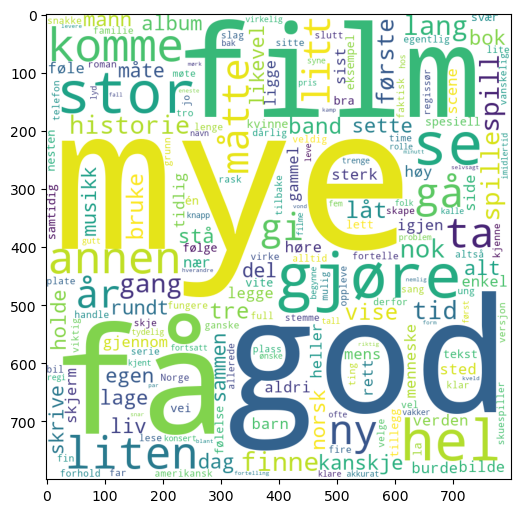

In [12]:
X_train_wc = []

for i in X_train_lemmas:
    for k in i.split():
        if k not in stops:
            X_train_wc.append(k)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                # stopwords = stopwords,
                min_font_size = 10).generate((' '.join(X_train_wc)))

# print(X_train_wc)
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)

plt.show()

Now that we have vectorized the data, one can see below that it produces a large array of mostly 0, as expected.

In [13]:
X_test = vectorizer.transform(X_test_lemmas).toarray()

X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 2.5 Classifier  
  
For the classifier we've tried several different ones. We tried several such as `MultinomialNB` and `BernoulliNB`, but they both produce results that were below what we expected to see. So in the end we went with `SGDClassifier` as it produced the best results out of the classifiers we tried. As shown below it performed well above the two other classifiers that we tried to implement. With that in mind the rest of the assignment will be done with the SGDClassifier.

In [14]:
classifierB = BernoulliNB()
classifierB.fit(X_train, y_train)
y_predB = classifierB.predict(X_test)
print(f'BernoulliNB: {accuracy_score(y_test, y_predB)}')

BernoulliNB: 0.5097375105842507


In [15]:
classifierM = MultinomialNB()
classifierM.fit(X_train, y_train)
y_predM = classifierM.predict(X_test)
print(f'MultinomialNB: {accuracy_score(y_test, y_predM)}')

MultinomialNB: 0.56731583403895


In [16]:
classifier = SGDClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [17]:
print(f'Non-rescaled: {accuracy_score(y_test, y_pred)}')

Non-rescaled: 0.6299745977984759


In [18]:
print(confusion_matrix(y_test, y_pred))

[[ 39  76  67]
 [ 31 435 132]
 [ 25 106 270]]


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.41      0.21      0.28       182
     Neutral       0.71      0.73      0.72       598
    Positive       0.58      0.67      0.62       401

    accuracy                           0.63      1181
   macro avg       0.56      0.54      0.54      1181
weighted avg       0.62      0.63      0.62      1181



### 2.6 Resampling  

For this data-set 63% accuracy is to be expected, but still quite bad. In an attempt to remedy this we tried resampling the data-set using `BorderlineSMOTE`. Effectively what it does is fill the data-set with more data in an attempt to equalize what is being provided to the classifier. In this data-set it creates significantly more negative and positive data-points for the classifier to work with.

In [20]:
resampler = BorderlineSMOTE(random_state=123)

X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)

Let's see how many values it has once resampled.

In [21]:
y_train_res.value_counts() # Rescaled

Neutral     4079
Negative    4079
Positive    4079
Name: label, dtype: int64

In [22]:
y_train.value_counts() # non-Rescaled

Neutral     4079
Positive    2624
Negative    1270
Name: label, dtype: int64

As you can see the difference in number of values quite significant.  

Now let's see what accuracy it achives when the input-data is equalized.

In [23]:
classifier_res = SGDClassifier()
classifier_res.fit(X_train_res, y_train_res)
y_pred_res = classifier_res.predict(X_test)

In [24]:
print(f'Rescaled: {accuracy_score(y_test, y_pred_res)}')

Rescaled: 0.6121930567315834


In [25]:
print(confusion_matrix(y_test, y_pred_res))

[[ 29  92  61]
 [ 39 458 101]
 [ 23 142 236]]


In [26]:
print(classification_report(y_test, y_pred_res))

              precision    recall  f1-score   support

    Negative       0.32      0.16      0.21       182
     Neutral       0.66      0.77      0.71       598
    Positive       0.59      0.59      0.59       401

    accuracy                           0.61      1181
   macro avg       0.52      0.50      0.50      1181
weighted avg       0.59      0.61      0.59      1181



### 2.7 Results Discussion  

The results of this sentimental analysis are not great, 63% accuracy is practically a coinflip and is quite bad, but is expected from the given data-set. In an attempt to improve the accuracy we rescaled the data-set to try and account for the skewed data-set, but still seeing quite bad results. The reason for this could be a poor choice of machine learning, but we think the main issue is that the skewed data-set doesn't give the model enough to go off of.  

Analysing the classification reports we can glean some information about the model. In the first classification report the model has a negative recall of `.19`, meaning that out of `100` negative sentences, it would misclassify `81` of them. These numbers are slightly improved in the rescaled classifier, to `.29` negative recall. The numbers of neutral and positive recall are significantly higher, but similarly are also quite poor. For negative precision we see it scores `.45` meaning that for 55% of the sentences if the classifier says it's negative, it's wrong. In the rescaled classifier the negative precision actually goes down significantly to `.33`, meaning that for 67% of the sentences the classifier says is negative is wrong.  

The main reason for this poor, but expected result is the severely skewed data-set as shown earlier. There are ~4000 neutral and ~2700 positive sentiments compared to only ~1200 negative sentiments. 